In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

## Load the Data

In [2]:
col_names = ['id','cycle','op_setting_1','op_setting_2','op_setting_3'] + [f's{i}' for i in range(1,22)]

train = pd.read_csv("train_FD001.txt", sep=" ", header=None)
test= pd.read_csv("test_FD001.txt", sep=" ", header=None)
rul = pd.read_csv("RUL_FD001.txt", sep=" ", header=None)

In [3]:
exclude = {'id', 'cycle', 'RUL', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'cycle_norm'}
sensor_cols = [c for c in col_names if c not in exclude and (c.startswith('s') or c.startswith('sensor_'))]

print("Detected sensor columns:", sensor_cols)

Detected sensor columns: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [4]:
train = train.drop([26, 27], axis=1)
test = test.drop([26, 27], axis=1)
train.columns = col_names
test.columns = col_names

In [5]:
train

,id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [6]:
test

,id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [7]:
train.shape

(20631, 26)

In [8]:
test.shape

(13096, 26)

In [9]:
rul.shape

(100, 2)

In [10]:
train.isna().sum()

,0
id,0
cycle,0
op_setting_1,0
op_setting_2,0
op_setting_3,0
s1,0
s2,0
s3,0
s4,0
s5,0


In [11]:
test.isna().sum()

,0
id,0
cycle,0
op_setting_1,0
op_setting_2,0
op_setting_3,0
s1,0
s2,0
s3,0
s4,0
s5,0


In [12]:
train.duplicated().sum()

np.int64(0)

In [13]:
test.duplicated().sum()

np.int64(0)

In [14]:
print("Number of engines in train dataset:", train['id'].nunique())

Number of engines in train dataset: 100


In [15]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


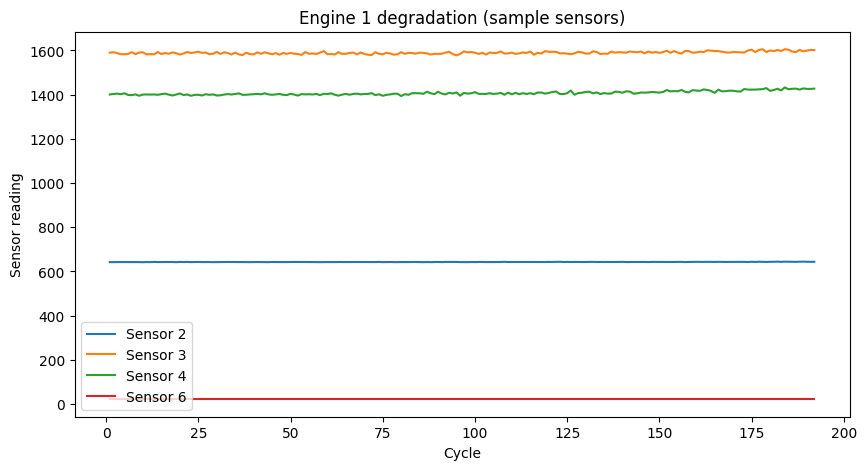

In [16]:
engine1 = train[train['id']==1]
plt.figure(figsize=(10,5))
plt.plot(engine1['cycle'], engine1['s2'], label='Sensor 2')
plt.plot(engine1['cycle'], engine1['s3'], label='Sensor 3')
plt.plot(engine1['cycle'], engine1['s4'], label='Sensor 4')
plt.plot(engine1['cycle'], engine1['s6'], label='Sensor 6')
plt.xlabel("Cycle")
plt.ylabel("Sensor reading")
plt.title("Engine 1 degradation (sample sensors)")
plt.legend()
plt.show()

In [17]:
#From the description of the dataframe we see some columns who seem to be constant (same min and max values) these wont help us so it is safe to drop them
nunique = train.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
print("Constant sensors:", constant_cols)

Constant sensors: ['op_setting_3', 's1', 's5', 's10', 's16', 's18', 's19']


In [18]:
train = train.drop(constant_cols , axis = 1)
test = test.drop(constant_cols , axis = 1)

In [19]:
train.shape

(20631, 19)

In [20]:
test.shape

(13096, 19)

In [21]:
train['max_cycle'] = train.groupby('id')['cycle'].transform('max')
train['RUL'] = train['max_cycle'] - train['cycle']
train = train.drop('max_cycle', axis=1)
train

,id,cycle,op_setting_1,op_setting_2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [22]:
rul_values=rul[0].values
test['max_cycle'] = test.groupby('id')['cycle'].transform('max')
test_rul = pd.DataFrame({"id": test['id'].unique(), "max_cycle": test.groupby('id')['cycle'].max().values, "truth_RUL": rul_values})

test= test.merge(test_rul, on=['id', 'max_cycle'], how='left')
test['RUL'] = test['truth_RUL'] + (test['max_cycle'] - test['cycle'])
test= test.drop(columns=['max_cycle', 'truth_RUL'])
test


,id,cycle,op_setting_1,op_setting_2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


## Exploratory Plots

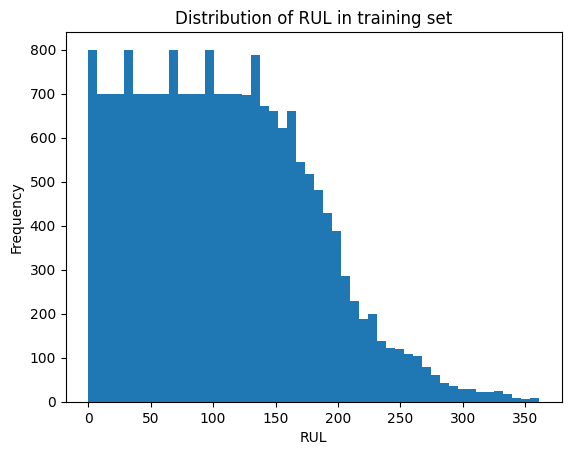

In [23]:
plt.hist(train['RUL'], bins=50)
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in training set")
plt.show()

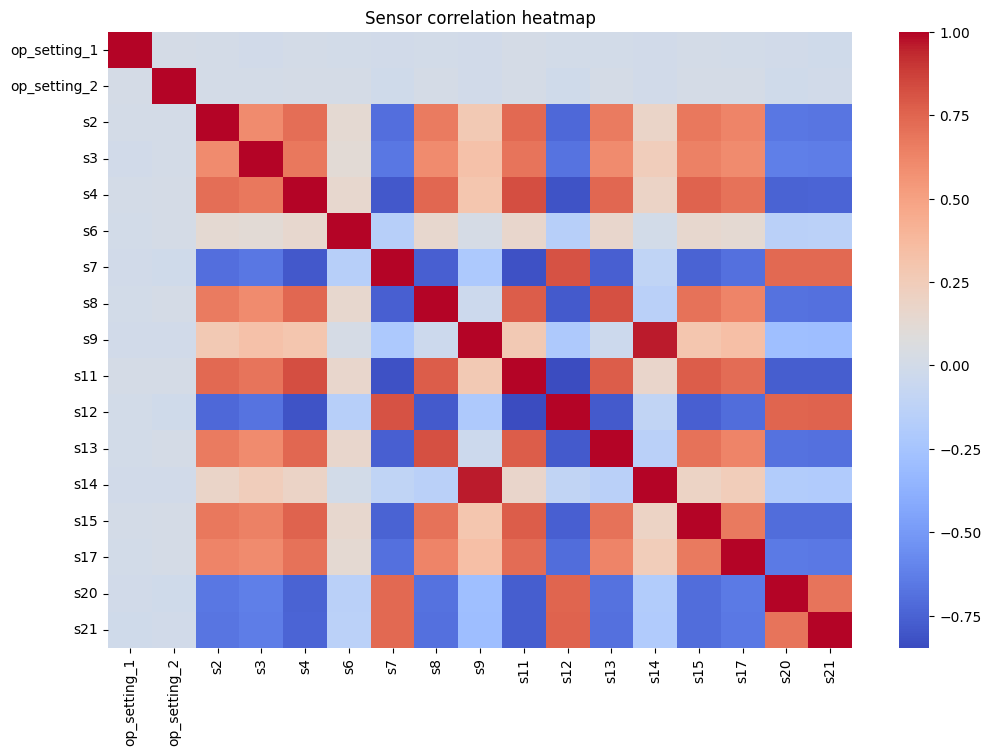

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(train.drop(columns=['id','cycle','RUL']).corr(), cmap="coolwarm")
plt.title("Sensor correlation heatmap")
plt.show()

#Handling Outliers

In [25]:
sensor_cols = [f's{i}' for i in range(1,22)]
useful_sensors = [col for col in sensor_cols if col not in constant_cols]
print("Useful sensors:", useful_sensors)


Useful sensors: ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


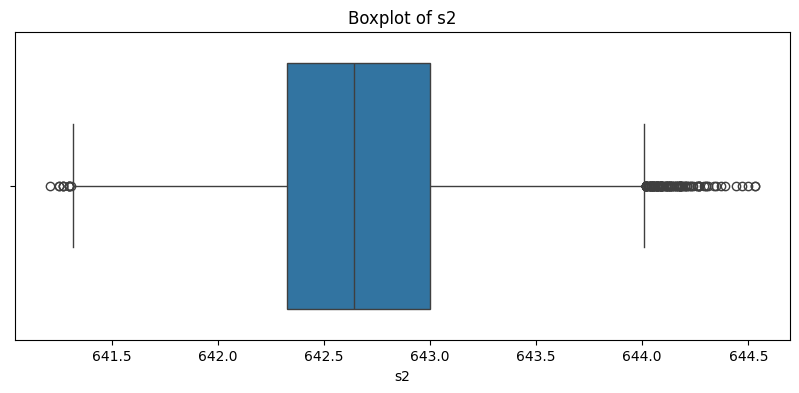

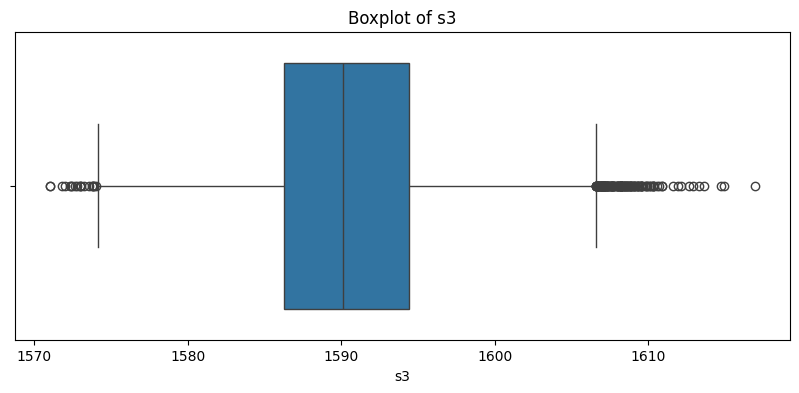

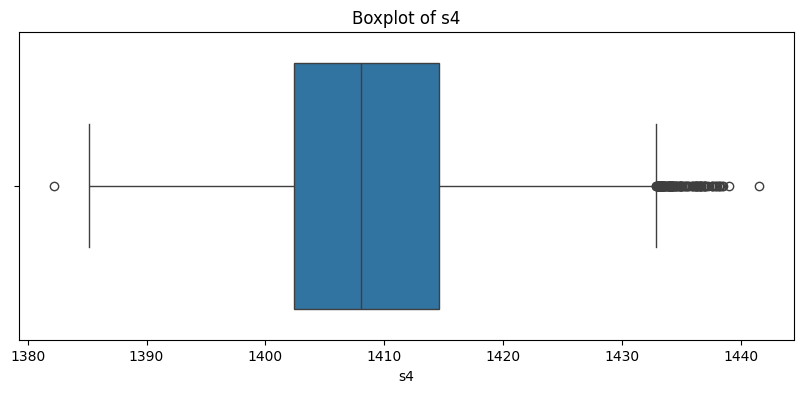

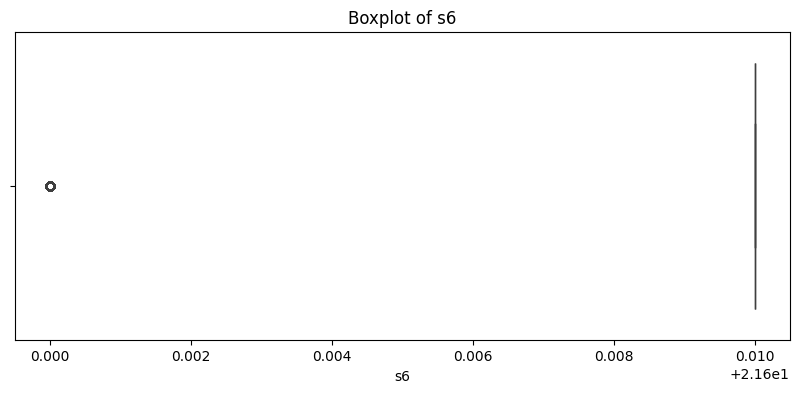

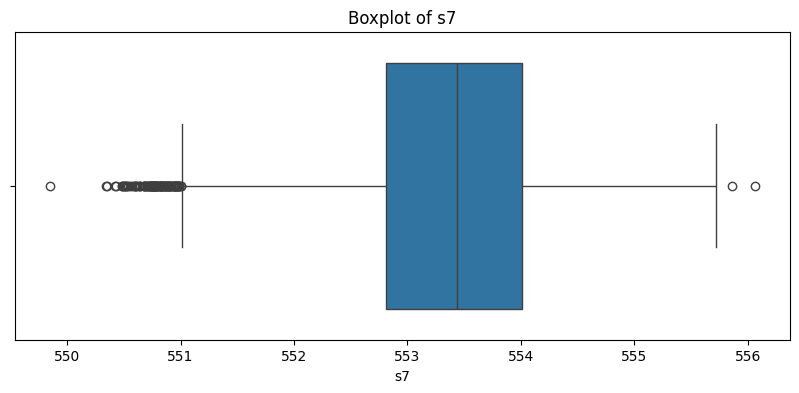

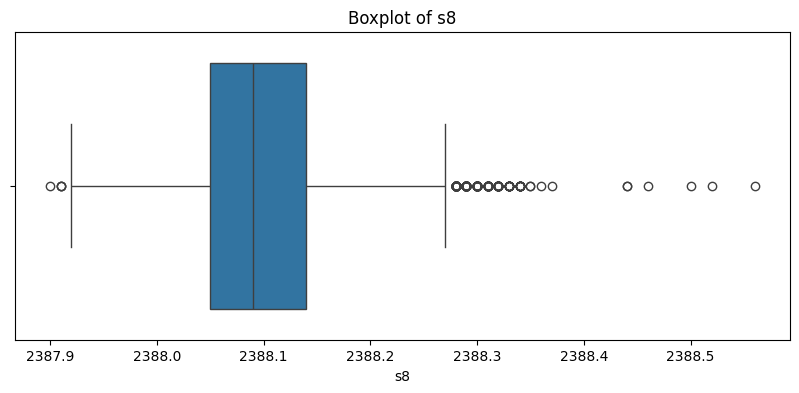

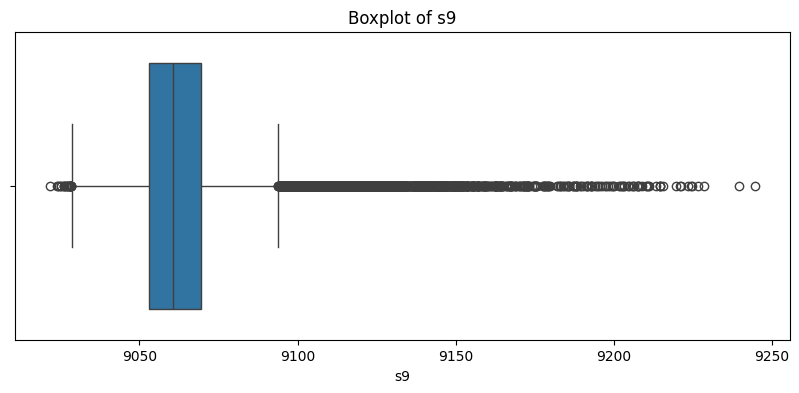

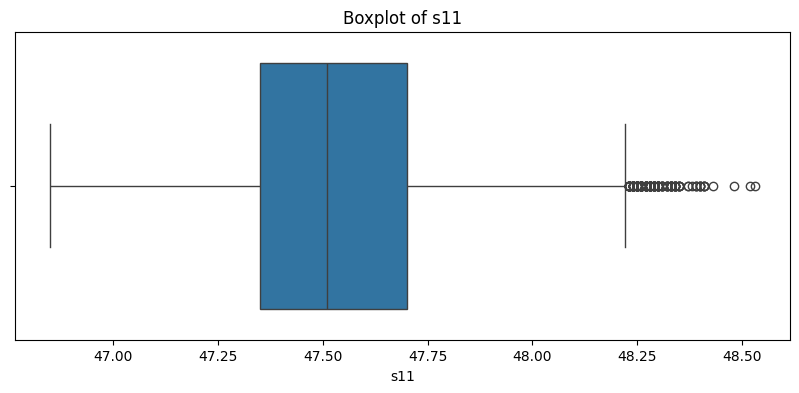

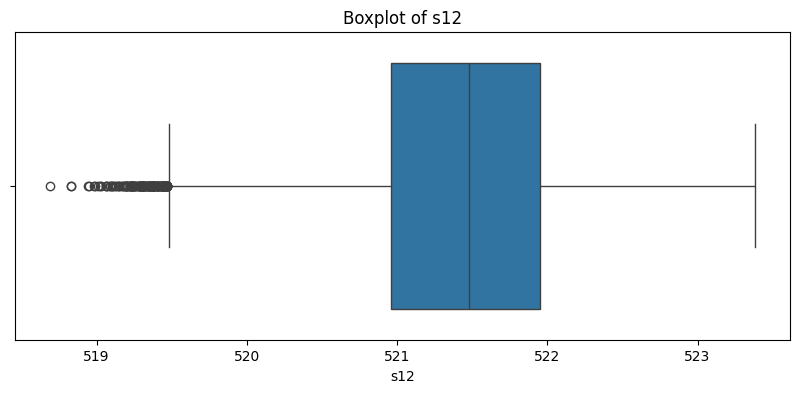

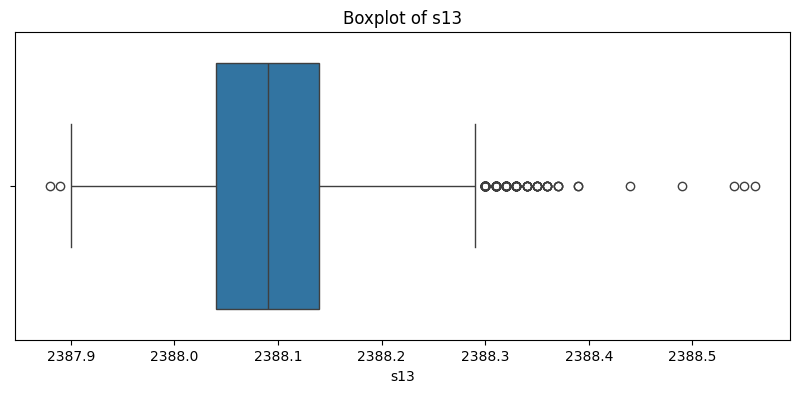

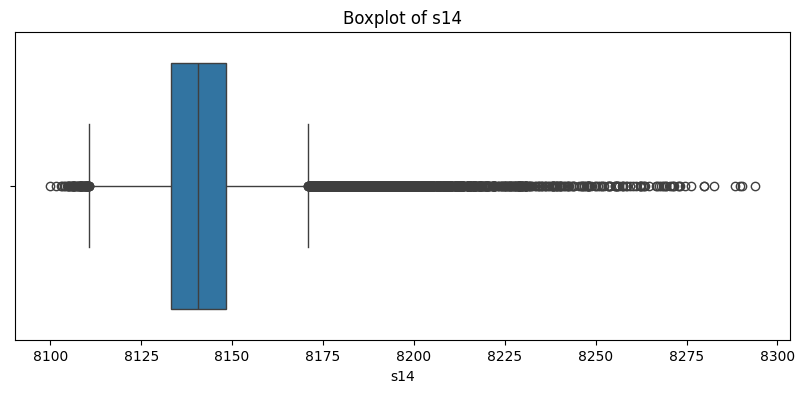

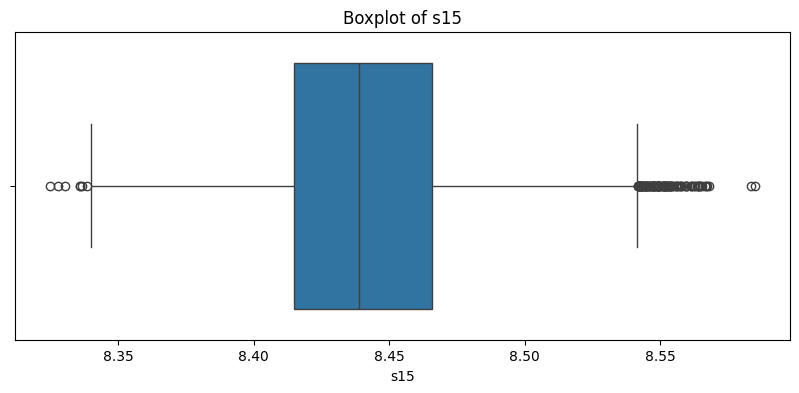

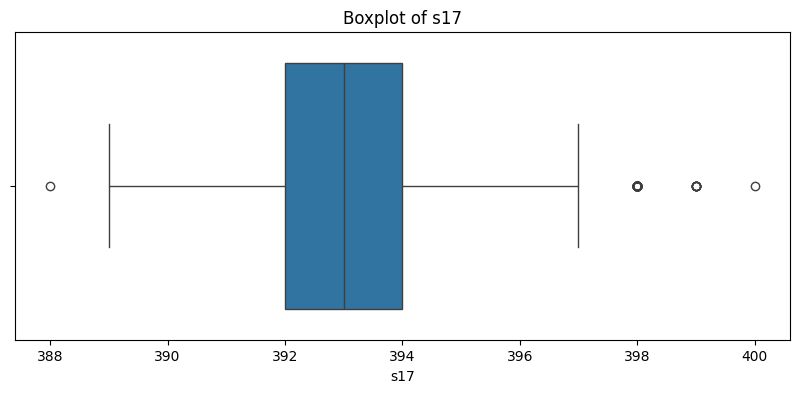

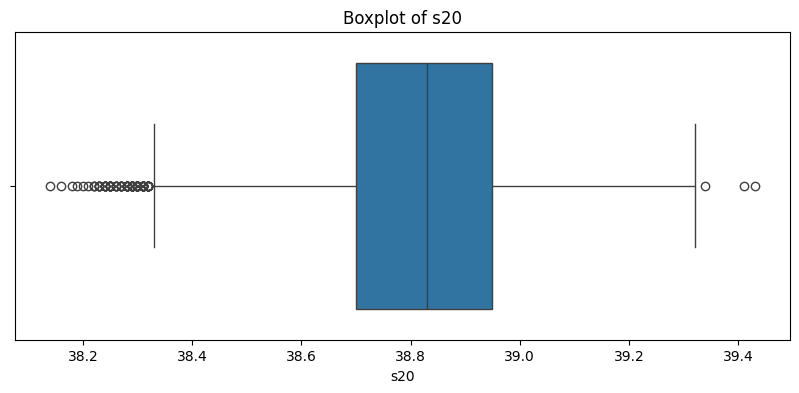

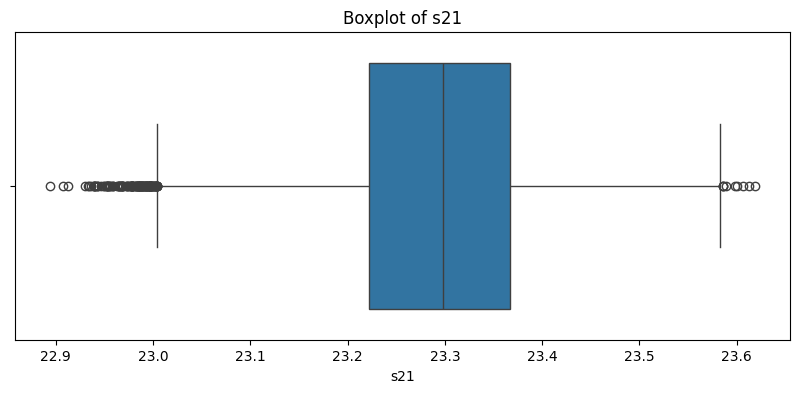

In [26]:
for col in useful_sensors:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [27]:
#Handling outliers is up for discussion as the outliers may be useful to show spikes that help in the occurence of failure and thats what helps us to detect
#for col in useful_sensors:
#    mean = train[col].mean()
#    std = train[col].std()
#    train[col+'_outlier'] = np.where(np.abs((train[col]-mean)/std) > 3, 1, 0)

## Simple Feature engineering

In [28]:
scaler = MinMaxScaler()
sensor_cols = [c for c in train.columns if c not in ['id','cycle','RUL']]

train[sensor_cols] = scaler.fit_transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

rolling mean with window = 3 (look back 3 cycles each time), smoother and shows actual trends
Rolling standard deviation (std) → measures variability

If it’s high, the engine is unstable

Rolling min/max → captures recent extremes

Rolling sum → cumulative signal in the last N cycles

In [29]:
#short term trends
for col in useful_sensors:
    train[col+'_avg5'] = train.groupby('id')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)
    test[col+'_avg5'] = test.groupby('id')[col].rolling(window=5, min_periods=1).mean().reset_index(0,drop=True)

In [30]:
for col in useful_sensors:
    train[col+'_std5'] = train.groupby('id')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True).fillna(0)
    test[col+'_std5'] = test.groupby('id')[col].rolling(window=5, min_periods=1).std().reset_index(0,drop=True).fillna(0)

In [31]:
#delta features see how fast things change
for col in useful_sensors:
    train[col+'_diff'] = train.groupby('id')[col].diff().fillna(0)
    test[col+'_diff'] = test.groupby('id')[col].diff().fillna(0)

In [32]:
train['cycle_norm'] = train['cycle'] / train.groupby('id')['cycle'].transform('max')
test['cycle_norm']  = test['cycle'] / test.groupby('id')['cycle'].transform('max')

# Milestone 2

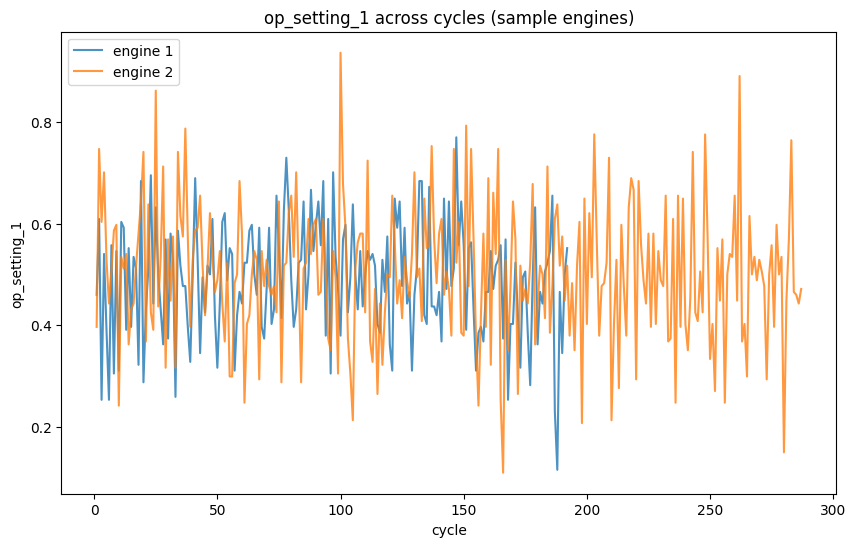

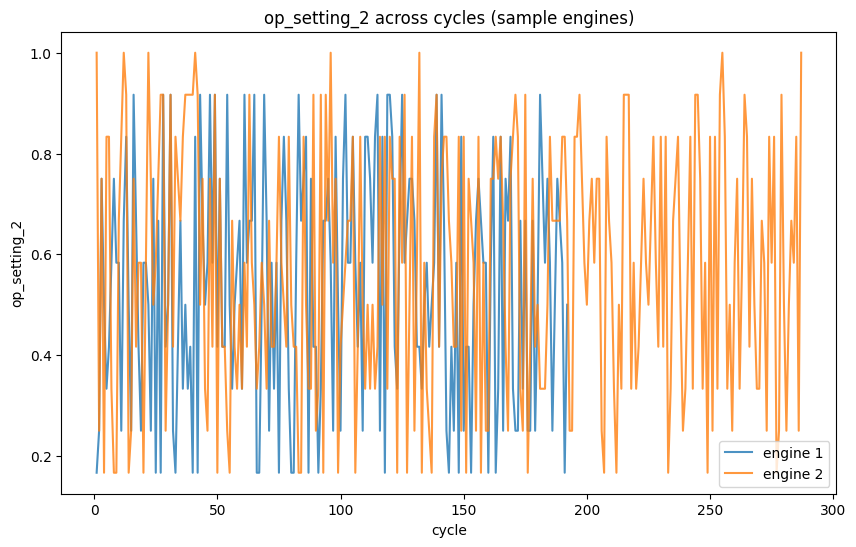

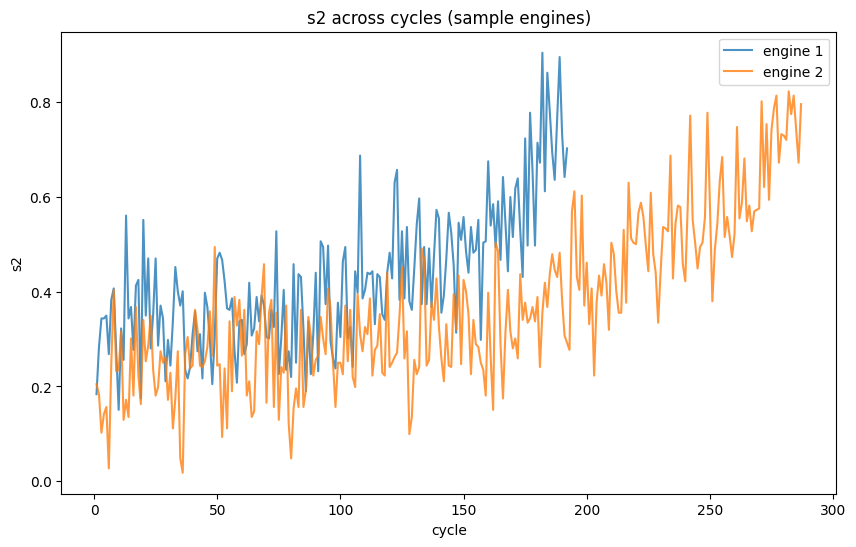

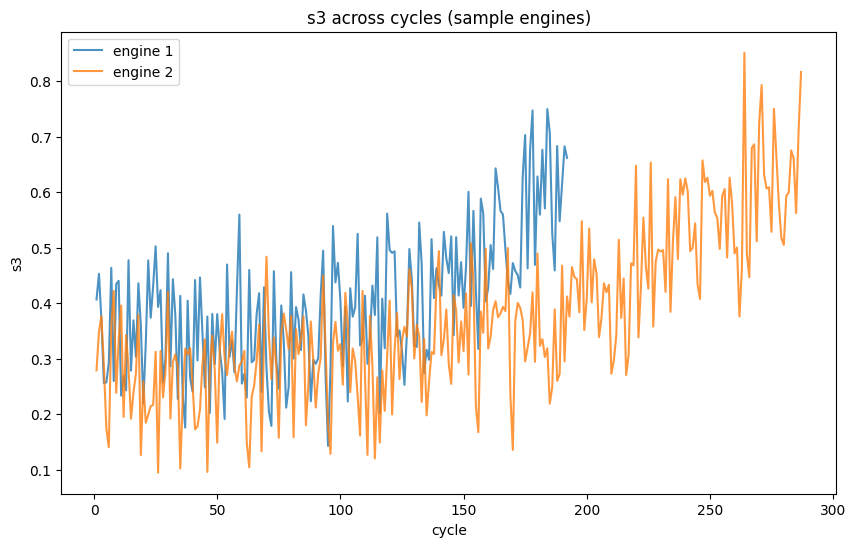

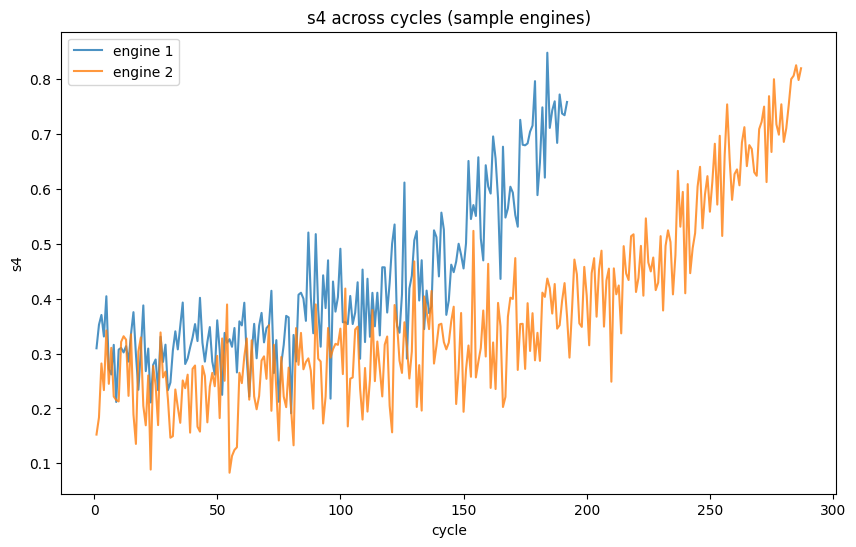

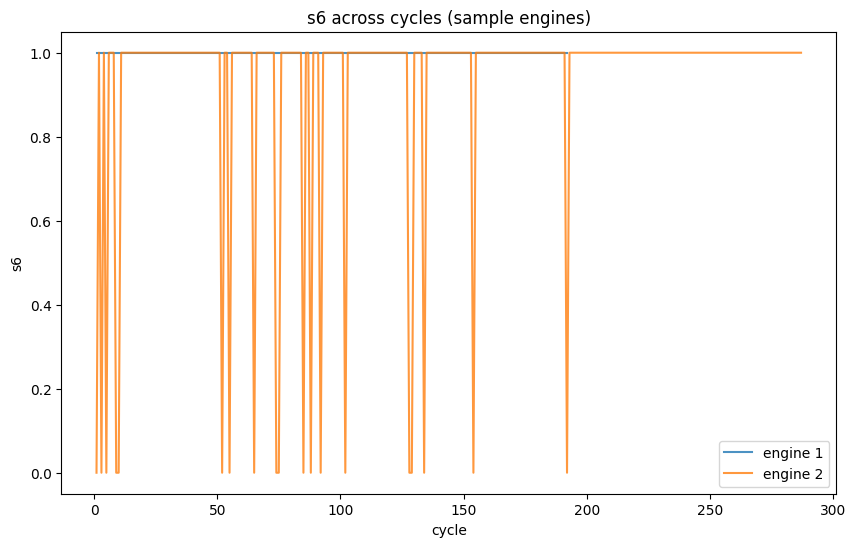

In [33]:
engines_to_plot=train['id'].unique()[:2]
sensors_to_plot = sensor_cols[:6]

for sensor in sensors_to_plot:
    plt.figure(figsize=(10,6))
    for engine in engines_to_plot:
      eng =train[train['id'] == engine]
      plt.plot(eng['cycle'], eng[sensor], label=f'engine {engine}', alpha=0.8)
    plt.title(f"{sensor} across cycles (sample engines)")
    plt.xlabel("cycle")
    plt.ylabel(sensor)
    plt.legend()
    plt.show()

In [34]:
from scipy.stats import linregress, spearmanr

results =[]
for sensor in sensor_cols:
  slopes =[]
  pvals = []
  for engine ,g in train.groupby('id'):
    if len(g) <3:
      continue
    lr = linregress(g['cycle'], g[sensor])
    slopes.append(lr.slope)
    pvals.append(lr.pvalue)
  slopes = np.array(slopes)
  pvals = np.array(pvals)
  median_slope = np.median(slopes)
  mean_slope = np.mean(slopes)
  frac_pos = np.mean(slopes > 0)
  frac_neg = np.mean(slopes < 0)
  frac_sig = np.mean(pvals < 0.05)

  rho, sp_p = spearmanr(train[sensor],train['RUL'])
  results.append({'sensor': sensor,'median_slope': median_slope,'mean_slope': mean_slope,'frac_pos': frac_pos,'frac_neg': frac_neg,'frac_sig_slope': frac_sig,'spearman_rho_vs_RUL': rho,'spearman_p': sp_p})
deg_df = pd.DataFrame(results).sort_values(by='frac_sig_slope', ascending=False)
deg_df.reset_index(drop=True, inplace=True)
deg_df.head(20)


,sensor,median_slope,mean_slope,frac_pos,frac_neg,frac_sig_slope,spearman_rho_vs_RUL,spearman_p
0,s2,1.596674e-03,0.001653,1.00,0.00,1.00,-0.628588,0.000000e+00
1,s20,-1.562337e-03,-0.001616,0.00,1.00,1.00,0.653336,0.000000e+00
2,s3,1.419136e-03,0.001420,1.00,0.00,1.00,-0.605609,0.000000e+00
3,s4,1.844902e-03,0.001872,1.00,0.00,1.00,-0.701771,0.000000e+00
4,s7,-1.595802e-03,-0.001699,0.00,1.00,1.00,0.678845,0.000000e+00
5,s8,1.056896e-03,0.001102,1.00,0.00,1.00,-0.573864,0.000000e+00
6,s17,1.414599e-03,0.001418,1.00,0.00,1.00,-0.629397,0.000000e+00
7,s12,-1.802467e-03,-0.001926,0.00,1.00,1.00,0.693149,0.000000e+00
8,s11,1.984857e-03,0.002010,1.00,0.00,1.00,-0.718132,0.000000e+00
9,s15,1.641923e-03,0.001684,1.00,0.00,1.00,-0.665905,0.000000e+00


1. Focus on slope direction & significance

A sensor shows degradation if it has a consistent slope (positive or negative) across engines.

frac_pos close to 1.0 → mostly positive slopes (sensor increases as cycles increase).

frac_neg close to 1.0 → mostly negative slopes (sensor decreases with cycles).

frac_sig_slope close to 1.0 → slopes are statistically significant (reliable trend).

s2, s3, s4, s8, s11, s13, s15, s17 have positive consistent slopes → they increase as the engine degrades.

s7, s12, s20, s21 have negative consistent slopes → they decrease as the engine degrades.

2. Check correlation with RUL (Remaining Useful Life)

spearman_rho_vs_RUL tells how strongly the sensor correlates with RUL.

Negative correlation → as RUL decreases (engine approaches failure), sensor value increases.

Positive correlation → as RUL decreases, sensor value decreases.


Strong negative correlations (good candidates): s2, s3, s4, s8, s11, s13, s15, s17.

Strong positive correlations: s7, s12, s20, s21.

Both are valid → what matters is consistency.

3. Decide useful vs. useless sensors

Useful sensors: high |rho| (≥0.5), frac_sig_slope ~ 1, consistent slope.

Weak sensors: very small slopes, low correlation, inconsistent sign.

From our output, the most useful sensors are:
s2, s3, s4, s7, s8, s11, s12, s13, s15, s17, s20, s21.

We can Drop the weak ones

s6, s14, s9 are borderline (weak correlation).

op_setting_1, op_setting_2 are not sensors

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(train[sensor_cols])
pca = PCA(n_components=None)
X = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
print("Explained variance ratio:", explained)
print("Cumulative:", np.cumsum(explained))

Explained variance ratio: [0.50978998 0.17019244 0.06148257 0.05277026 0.04511109 0.02296592
 0.02089122 0.01896348 0.01777373 0.01674084 0.01497876 0.01247696
 0.01185749 0.01054707 0.00700629 0.0056366  0.00081531]
Cumulative: [0.50978998 0.67998242 0.74146499 0.79423525 0.83934633 0.86231225
 0.88320347 0.90216695 0.91994068 0.93668152 0.95166027 0.96413723
 0.97599472 0.9865418  0.99354809 0.99918469 1.        ]


In [36]:
for i in range(X_pca.shape[1]):
    train[f'PC{i+1}'] = X_pca[:, i]

pc_corrs = []
for i in range(X_pca.shape[1]):
    rho, pval = spearmanr(train[f'PC{i+1}'], train['RUL'])
    pc_corrs.append((i+1, rho, pval))

pc_corrs_df = pd.DataFrame(pc_corrs, columns=['PC','spearman_rho_vs_RUL','pval'])

In [37]:
pc1 = X_pca[:, 0]
HI = 1 - (pc1 - pc1.min()) / (pc1.max() - pc1.min())
train['HI'] = HI

In [38]:
X_test_prep = imputer.transform(test[sensor_cols])
X_test_prep = scaler.transform(X_test_prep)
X_test_pca  = pca.transform(X_test_prep)

for i in range(X_test_pca.shape[1]):
    test[f'PC{i+1}'] = X_test_pca[:, i]

pc1_test = X_test_pca[:, 0]
HI_test = 1 - (pc1_test - pc1.min()) / (pc1.max() - pc1.min())
test['HI'] = HI_test


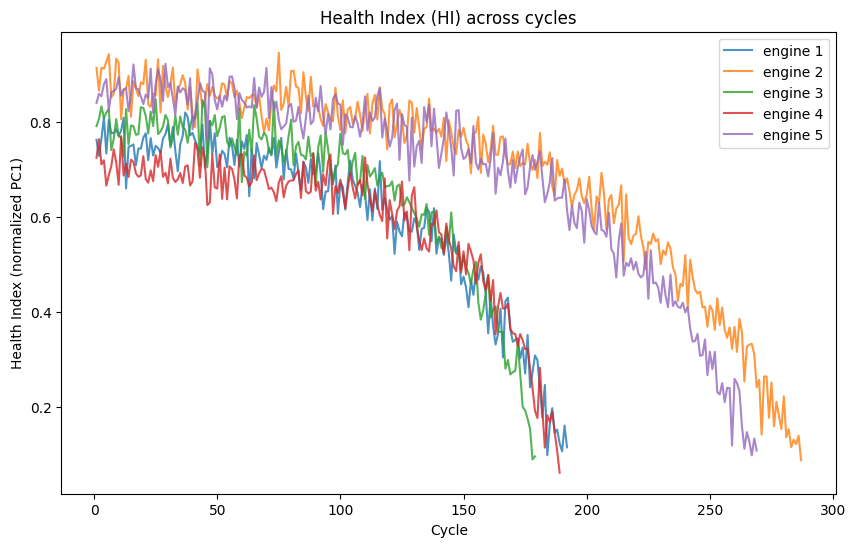

In [39]:
engines_to_plot = train['id'].unique()[:5]  # first 5 engines for example

plt.figure(figsize=(10,6))
for engine in engines_to_plot:
    eng = train[train['id'] == engine]
    plt.plot(eng['cycle'], eng['HI'], label=f'engine {engine}', alpha=0.8)

plt.title("Health Index (HI) across cycles")
plt.xlabel("Cycle")
plt.ylabel("Health Index (normalized PC1)")
plt.legend()
plt.show()


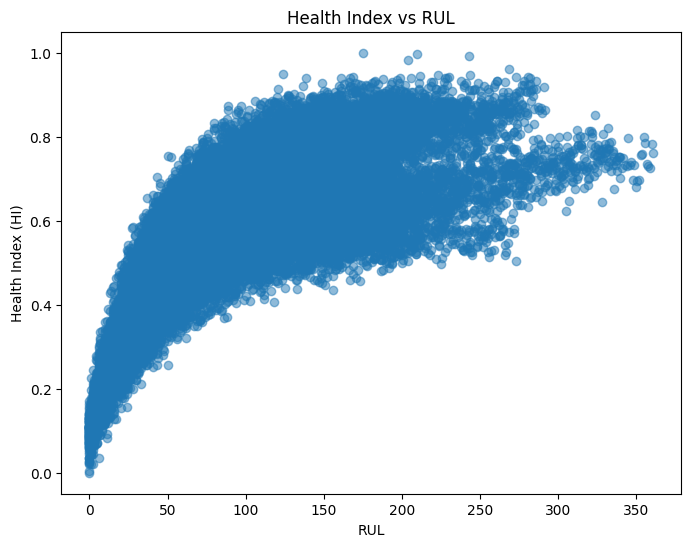

Spearman correlation between HI and RUL: 0.7643845693427276 p-value: 0.0


In [40]:
plt.figure(figsize=(8,6))
plt.scatter(train['RUL'], train['HI'], alpha=0.5)
plt.title("Health Index vs RUL")
plt.xlabel("RUL")
plt.ylabel("Health Index (HI)")
plt.show()

rho, pval = spearmanr(train['HI'], train['RUL'])
print("Spearman correlation between HI and RUL:", rho, "p-value:", pval)

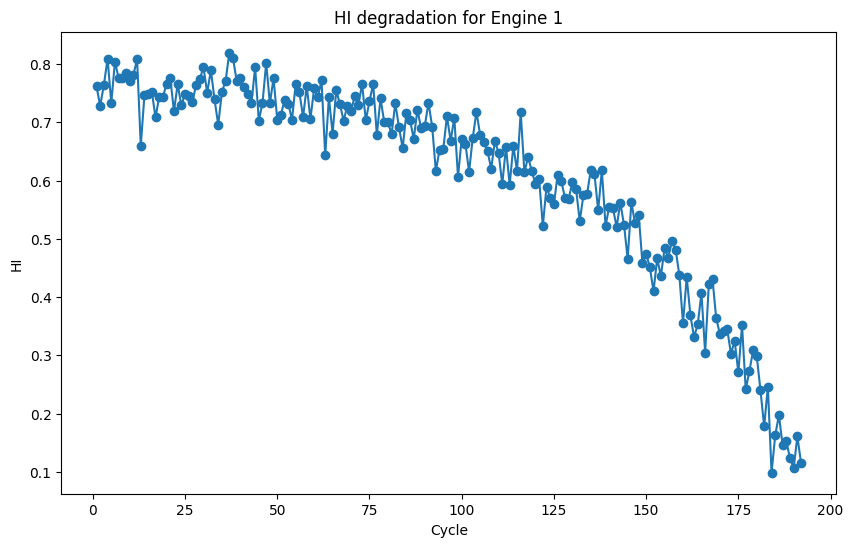

In [41]:
engine_id = 1
eng = train[train['id'] == engine_id]

plt.figure(figsize=(10,6))
plt.plot(eng['cycle'], eng['HI'], marker='o')
plt.title(f"HI degradation for Engine {engine_id}")
plt.xlabel("Cycle")
plt.ylabel("HI")
plt.show()


## Milestone 3

Regression

In [43]:
useful_features = ['cycle_norm', 'HI'] + [
    's2', 's3', 's4', 's7', 's8', 's11', 's12', 's15', 's17', 's20', 's21'
]

X = train[useful_features]
y = train['RUL']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


X_train: (16504, 13) y_train: (16504,)
X_val: (4127, 13) y_val: (4127,)


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)

    results[name] = {"RMSE": rmse, "R2": r2}

import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


                        RMSE        R2
Linear Regression  28.010634  0.828271
Random Forest      28.822416  0.818173
Gradient Boosting  28.071753  0.827521


In [ ]:
#pip install xgboost==1.7.6

### XGBOOST

In [45]:
from xgboost import XGBRegressor, callback
feature_cols = [c for c in train.columns if c not in ['id','cycle','RUL']]
X = train[feature_cols]
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0,
    reg_alpha=0.0
)

In [47]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=30,
    verbose=50
)

y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"XGBoost RMSE: {rmse:.4f}")
print(f"XGBoost R²: {r2:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:121.51667
[50]	validation_0-rmse:26.98383
[100]	validation_0-rmse:24.77814
[150]	validation_0-rmse:24.37211
[200]	validation_0-rmse:24.25302
[250]	validation_0-rmse:24.13522
[300]	validation_0-rmse:24.07065
[350]	validation_0-rmse:24.01949
[400]	validation_0-rmse:23.96422
[450]	validation_0-rmse:23.91765
[499]	validation_0-rmse:23.88200
XGBoost RMSE: 23.8796
XGBoost R²: 0.8752


### LSTM

In [ ]:
#There are 2 methods to use LSTM, I will use the sliding window method as it looks at the last N cycles, The other method would be unhelpful as it will look at all cycles
def create_sequences(df, seq_len, features, target_col='RUL'):
    X, y = [], []
    for eng_id, eng_df in df.groupby('id'):
        eng_df = eng_df.reset_index(drop=True)
        values = eng_df[features].values
        targets = eng_df[target_col].values

        for i in range(len(eng_df) - seq_len + 1):
            X.append(values[i:i+seq_len])
            y.append(targets[i+seq_len-1])  # predict last cycle RUL

    return np.array(X), np.array(y)

In [ ]:
seq_len = 50
useful_sensors = ['s2','s3','s4','s7','s8','s11','s12','s15','s17','s20','s21']  # from your degradation study
features = useful_sensors + ['cycle_norm']

X_train, y_train = create_sequences(train, seq_len, features)
X_test, y_test   = create_sequences(test, seq_len, features)

In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_len, len(features))),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lstm.h5', monitor='val_loss', save_best_only=True)
]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM R²:   {r2:.4f}")

## Classification

In [48]:
def create_labels(rul, thresholds=(130, 30)):
    if rul > thresholds[0]:
        return 0  # healthy
    elif rul > thresholds[1]:
        return 1  # warning
    else:
        return 2  # critical

train["label"] = train["RUL"].apply(create_labels)
test["label"]  = test["RUL"].apply(create_labels)

In [49]:
X_train = train.drop(columns=["id","cycle","RUL","label"])
y_train = train["label"]

X_test = test.drop(columns=["id","cycle","RUL","label"])
y_test = test["label"]

In [51]:
X_test = X_test[X_train.columns]

In [56]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, probs, multi_class='ovr', average='weighted')
    else:
        probs = None
        roc_auc = None

    report = classification_report(y_test, preds, output_dict=True)

    results[name] = {
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1": report['weighted avg']['f1-score'],
        "ROC-AUC": roc_auc
    }


import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


                     Precision    Recall        F1   ROC-AUC
Logistic Regression   0.795862  0.732896  0.735013  0.861340
Random Forest         0.802536  0.748091  0.749383  0.871497
XGBoost               0.768919  0.659362  0.686298  0.806347


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc  = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat  = to_categorical(y_test_enc)


In [58]:
def create_sequences(data, labels, seq_len=30):
    Xs, ys = [], []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
        ys.append(labels[i+seq_len])
    return np.array(Xs), np.array(ys)

seq_len = 30
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train_enc, seq_len)
X_test_seq, y_test_seq   = create_sequences(X_test.values, y_test_enc, seq_len)

print(X_train_seq.shape, y_train_seq.shape)

(20601, 30, 81) (20601,)


In [59]:
model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=10, batch_size=64)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.7039 - loss: 0.6293 - val_accuracy: 0.7170 - val_loss: 0.7555
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8421 - loss: 0.3689 - val_accuracy: 0.7165 - val_loss: 0.8258
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8566 - loss: 0.3381 - val_accuracy: 0.6985 - val_loss: 0.9662
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8638 - loss: 0.3244 - val_accuracy: 0.6782 - val_loss: 1.2218
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8685 - loss: 0.3081 - val_accuracy: 0.6860 - val_loss: 1.1965
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8770 - loss: 0.2948 - val_accuracy: 0.7089 - val_loss: 0.9969
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8891 - loss: 0.2738 - val_accuracy: 0.6975 - val_loss: 1.3045
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9012 - loss: 0.2422 - val_a

In [60]:
from sklearn.metrics import classification_report
lstm_preds = np.argmax(model.predict(X_test_seq), axis=1)
print(classification_report(y_test_seq, lstm_preds, target_names=encoder.classes_.astype(str)))

409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
              precision    recall  f1-score   support

           0       0.95      0.51      0.66      7484
           1       0.57      0.94      0.71      5250
           2       0.69      0.83      0.75       332

    accuracy                           0.69     13066
   macro avg       0.74      0.76      0.71     13066
weighted avg       0.79      0.69      0.69     13066



This means the LSTM is overfitting patterns for class 1 and under-representing class 0.

## Model Optimization

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [63]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=20,
    scoring="f1_weighted",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print("Best Random Forest Params:", rf_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': False}


In [67]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    eval_metric="mlogloss",
    random_state=42
)


In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [72]:
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=20,
    scoring="f1_weighted",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
print("Best XGBoost Params:", xgb_random.best_params_)

InvalidParameterError: The 'estimator' parameter of RandomizedSearchCV must be an object implementing 'fit'. Got <module 'xgboost' from '/usr/local/lib/python3.12/dist-packages/xgboost/__init__.py'> instead.

In [65]:
voting_clf = VotingClassifier(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    voting="soft",  # soft = uses probabilities better
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)

NameError: name 'best_xgb' is not defined

In [ ]:
models = {
    "Random Forest (Tuned)": best_rf,
    "XGBoost (Tuned)": best_xgb,
    "Voting Ensemble": voting_clf
}

for name, model in models.items():
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    report = classification_report(y_test, preds, output_dict=False)
    roc_auc = roc_auc_score(y_test, probs, multi_class="ovr")
    print(f"\n{name} Results:")
    print(report)
    print(f"ROC-AUC: {roc_auc:.4f}")